In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torch
from torch import nn
from easy_tpp.preprocess.event_tokenizer import EventTokenizer
from easy_tpp.config_factory import DataSpecConfig
from models.encoders.gru import GRUTPPEncoder
from models.decoders.rmtpp import RMTPPDecoder, RMTPPLoss
from models import TPPModel, VAETPPModel
from torch.utils.data import DataLoader, Dataset
from utils.evaluatetpp import evaluate_tpp_model, evaluate_vae_model, calculate_event_metrics
from scipy import integrate

In [18]:
def preprocess_data(raw_data):
    # Validate input
    if not raw_data:
        raise ValueError("Input data is empty")
        
    # Create input data dictionary
    input_data = {
        'time_seqs': [[x["time_since_start"] for x in seq] for seq in raw_data],
        'type_seqs': [[x["type_event"] for x in seq] for seq in raw_data],
        'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in raw_data]
    }

    filtered_data = {
        k: [seq for seq in v if len(seq) > 0]
        for k, v in input_data.items()
    }
    
    if not filtered_data['type_seqs']:
        raise ValueError("No valid sequences found after filtering (all sequences were empty)")
        
    return filtered_data

def collate_fn(batch, config):
    tokenizer = EventTokenizer(config)
    tokenizer.padding_side = 'right'
    seq_lengths = [batch_item['sequence_length'] for batch_item in batch]  
    padded_batch = tokenizer.pad(batch, 
                                 return_tensors='pt',
                                 return_attention_mask=None,
                                 padding='longest')
    padded_batch['sequence_length'] = torch.tensor(seq_lengths)
    
    return padded_batch

In [19]:
class EventDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['type_seqs'])

    def __getitem__(self, idx):
        return {
            'time_seqs': self.data['time_seqs'][idx],
            'type_seqs': self.data['type_seqs'][idx],
            'time_delta_seqs': self.data['time_delta_seqs'][idx],
            'sequence_length': len(self.data['type_seqs'][idx])
        }

In [20]:
def plot_event_sequence(time_seqs, type_seqs, time_delta_seqs, sequence_length, calculated_deltas, decoder_output, num_samples=5):
    for i in range(num_samples):
        time_seq = time_seqs[i].detach().cpu().numpy()
        type_seq = type_seqs[i].detach().cpu().numpy()
        time_delta_seq = time_delta_seqs[i].detach().cpu().numpy()
        seq_len = sequence_length[i].item()
        pred_time_delta_seq = calculated_deltas[i].detach().cpu().numpy() if calculated_deltas is torch.Tensor else calculated_deltas
        pred_mark_logits = decoder_output.mark_logits[i].detach().cpu().numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(time_seq[:seq_len], type_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], np.argmax(pred_mark_logits[:seq_len], axis=-1), 'o-', label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Event Type')
        plt.title('Event Sequence')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(time_seq[:seq_len], time_delta_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], pred_time_delta_seq[:seq_len], 'o-', label='Calculated')
        plt.xlabel('Time')
        plt.ylabel('Time Delta')
        plt.title('Time Delta Sequence')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [21]:
dev_dict = pkl.load(open('data/taxi/dev.pkl', 'rb'))
test_dict = pkl.load(open('data/taxi/test.pkl', 'rb'))
train_dict = pkl.load(open('data/taxi/train.pkl', 'rb'))

train_data = train_dict['train']
test_data = test_dict['test']
dev_data = dev_dict['dev']

In [22]:
dim_process = train_dict['dim_process']
config = DataSpecConfig.parse_from_yaml_config({
    'num_event_types': dim_process,
    'pad_token_id': dim_process
})

In [23]:
# Create datasets
preprocessed_train = preprocess_data(train_data)
preprocessed_test = preprocess_data(test_data)

train_dataset = EventDataset(preprocessed_train)
test_dataset = EventDataset(preprocessed_test)

# Create data loaders with collate function and arguments to prepare_data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)

In [24]:
HIDDEN_DIM = 128
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

tpp_model = TPPModel(config, hidden_dim=HIDDEN_DIM, mlp_dim=MLP_DIM, device=device).to(device)

# Training loop
num_epochs = 200
optimizer = torch.optim.Adam(tpp_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    tpp_model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        decoder_output = tpp_model(batch)
        time_loss, mark_loss, total_loss = tpp_model.compute_loss(batch, decoder_output)
        total_loss.backward()
        optimizer.step()
        total_train_loss += total_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Evaluate on test data
    tpp_model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            decoder_output = tpp_model(batch)
            _, _, total_loss = tpp_model.compute_loss(batch, decoder_output)
            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")

Epoch 1/200, Train Loss: 1.1065
Epoch 1/200, Test Loss: 0.6223
Epoch 2/200, Train Loss: 0.4306
Epoch 2/200, Test Loss: 0.0209
Epoch 3/200, Train Loss: -0.2050
Epoch 3/200, Test Loss: -0.3723
Epoch 4/200, Train Loss: -0.4390
Epoch 4/200, Test Loss: -0.5601
Epoch 5/200, Train Loss: -0.6025
Epoch 5/200, Test Loss: -0.6952
Epoch 6/200, Train Loss: -0.7197
Epoch 6/200, Test Loss: -0.8154
Epoch 7/200, Train Loss: -0.8222
Epoch 7/200, Test Loss: -0.9133
Epoch 8/200, Train Loss: -0.9159
Epoch 8/200, Test Loss: -0.9942
Epoch 9/200, Train Loss: -0.9758
Epoch 9/200, Test Loss: -1.0363
Epoch 10/200, Train Loss: -1.0412
Epoch 10/200, Test Loss: -1.0897
Epoch 11/200, Train Loss: -1.0806
Epoch 11/200, Test Loss: -1.1223
Epoch 12/200, Train Loss: -1.1163
Epoch 12/200, Test Loss: -1.1576
Epoch 13/200, Train Loss: -1.1473
Epoch 13/200, Test Loss: -1.1872
Epoch 14/200, Train Loss: -1.1791
Epoch 14/200, Test Loss: -1.2179
Epoch 15/200, Train Loss: -1.2108
Epoch 15/200, Test Loss: -1.2175
Epoch 16/200, Tra

In [25]:
tpp_eval_metrics = evaluate_tpp_model(tpp_model, test_loader, config, device=device)

/home/jy384/projects/ProbabilisticTPP/utils/evaluatetpp.py:96: RuntimeWarning: overflow encountered in exp
  - np.exp(


In [26]:
tpp_eval_metrics

{'time_mae': 0.02932517999453523,
 'time_rmse': 0.0409275004720451,
 'event_accuracy': 0.9998650472334683,
 'event_total': 14820,
 'type_metrics': {'type_0': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_2': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_3': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_4': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_5': {'precision': 0.9982014388489209,
   'recall': 1.0,
   'f1': 0.9990999099909991},
  'type_6': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_7': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_8': {'precision': 0.9998495788206979,
   'recall': 0.9998495788206979,
   'f1': 0.9998495788206979},
  'type_9': {'precision': 1.0, 'recall': 0.5, 'f1': 0.6666666666666666}},
 'predicted_intervals': [0.0,
  0.24517363583953247,
  0.19119582787452716,
  0.06103152362767261,
  0.025005337062357746,
  0.1288793826902469,
  0.09550919510384714,
  0

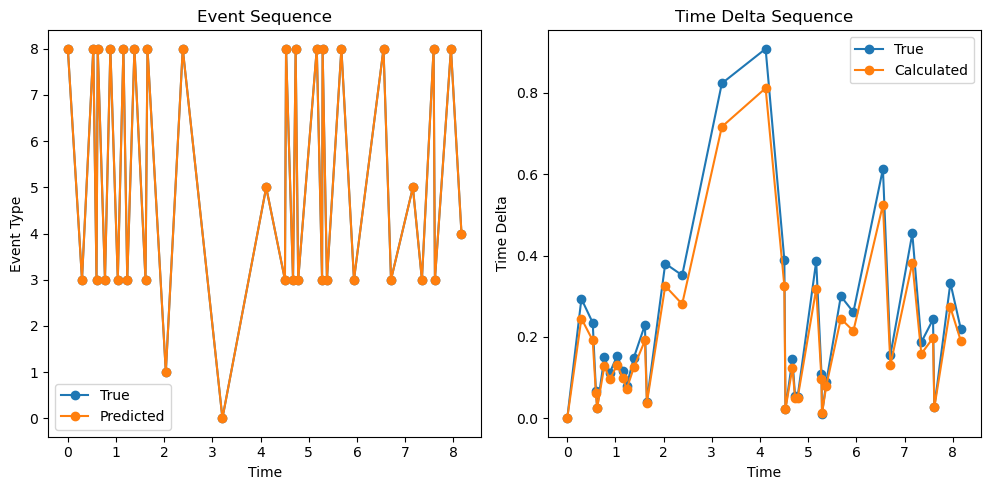

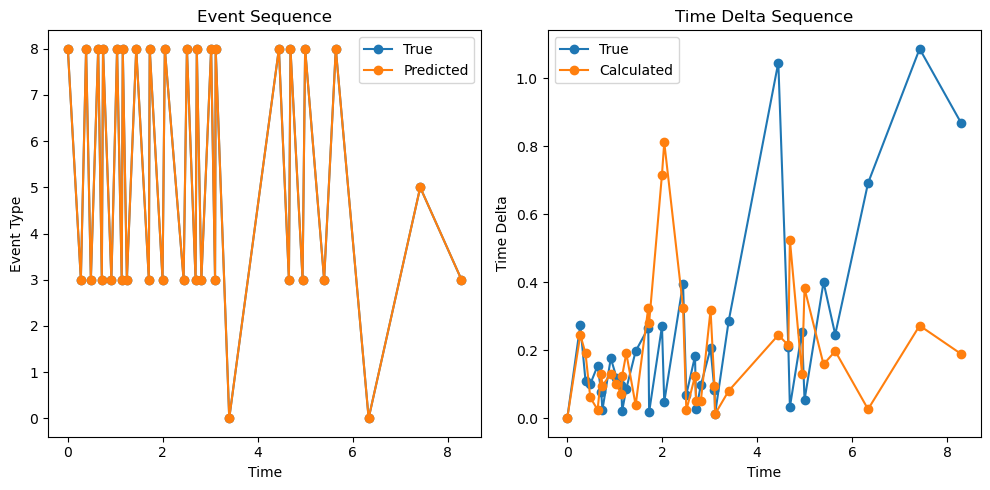

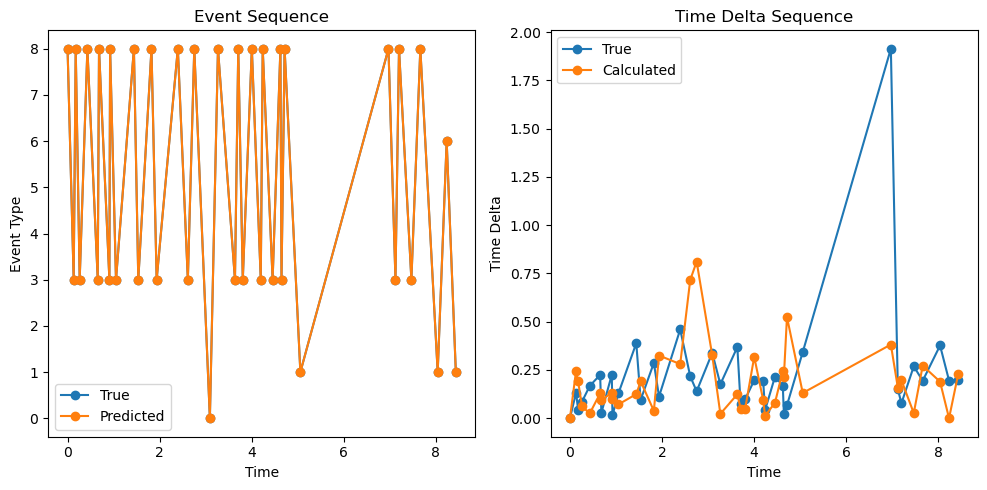

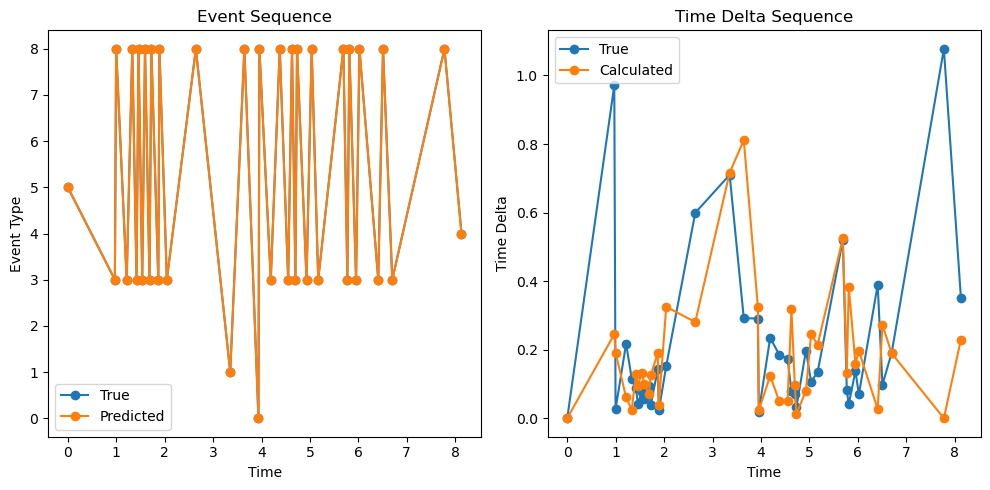

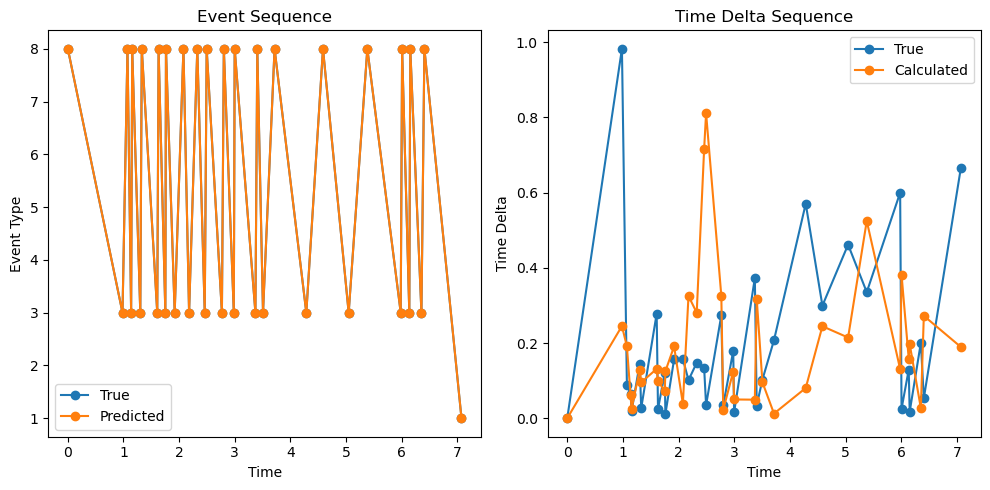

In [27]:
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = tpp_model(batch)
    plot_event_sequence(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        tpp_eval_metrics['predicted_intervals'], 
        decoder_output
    )
    break

In [28]:
# reload VAETPPModel
import importlib
import models
importlib.reload(models)
from models import TPPModel, VAETPPModel

HIDDEN_DIM = 128
LATENT_DIM = 32
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

# calculate the number of steps for beta annealing and warmup
num_epochs = 200
num_steps = len(train_loader) * num_epochs
cyclic_steps = num_steps // 5
warmup_steps = len(train_loader) * 20

vae_model = VAETPPModel(config, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, mlp_dim=MLP_DIM, device=device, beta_steps=num_steps, warmup_steps=warmup_steps, beta_start=0, beta_end=0.5, l1_lambda=0.000, l2_lambda=0.000).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

# One cycle learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    anneal_strategy='cos',
)

# Training loop with beta annealing
for epoch in range(num_epochs):
    vae_model.train()
    total_train_loss = 0
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        decoder_output = vae_model(batch)
        time_loss, mark_loss, total_loss = vae_model.compute_loss(batch, decoder_output)
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += total_loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    vae_model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            decoder_output = vae_model(batch)
            _, _, total_loss = vae_model.compute_loss(batch, decoder_output)
            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")


Epoch 1/200, Train Loss: 2.8184
Epoch 1/200, Test Loss: 2.7405
Epoch 2/200, Train Loss: 2.6623
Epoch 2/200, Test Loss: 2.5738


Epoch 3/200, Train Loss: 2.4748
Epoch 3/200, Test Loss: 2.3454
Epoch 4/200, Train Loss: 2.1975
Epoch 4/200, Test Loss: 2.0134
Epoch 5/200, Train Loss: 1.8326
Epoch 5/200, Test Loss: 1.6266
Epoch 6/200, Train Loss: 1.4695
Epoch 6/200, Test Loss: 1.3005
Epoch 7/200, Train Loss: 1.2088
Epoch 7/200, Test Loss: 1.0966
Epoch 8/200, Train Loss: 1.0440
Epoch 8/200, Test Loss: 0.9562
Epoch 9/200, Train Loss: 0.9238
Epoch 9/200, Test Loss: 0.8488
Epoch 10/200, Train Loss: 0.8351
Epoch 10/200, Test Loss: 0.7739
Epoch 11/200, Train Loss: 0.7717
Epoch 11/200, Test Loss: 0.7218
Epoch 12/200, Train Loss: 0.7273
Epoch 12/200, Test Loss: 0.6876
Epoch 13/200, Train Loss: 0.6960
Epoch 13/200, Test Loss: 0.6548
Epoch 14/200, Train Loss: 0.5986
Epoch 14/200, Test Loss: 0.5036
Epoch 15/200, Train Loss: 0.4911
Epoch 15/200, Test Loss: 0.4419
Epoch 16/200, Train Loss: 0.4341
Epoch 16/200, Test Loss: 0.3825
Epoch 17/200, Train Loss: 0.3743
Epoch 17/200, Test Loss: 0.3253
Epoch 18/200, Train Loss: 0.3191
Epoch 

In [29]:
vae_eval_metrics = evaluate_vae_model(vae_model, test_loader, config, device=device)

In [30]:
# vae_eval_metrics

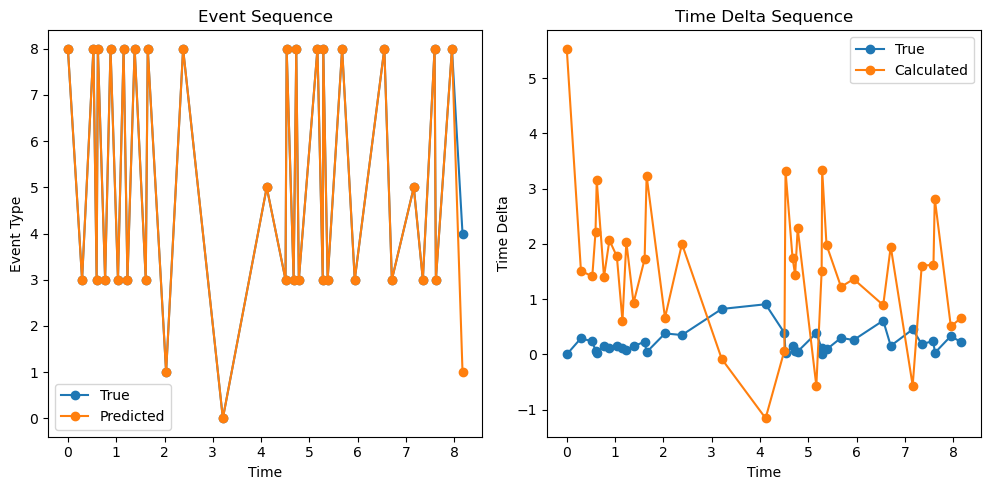

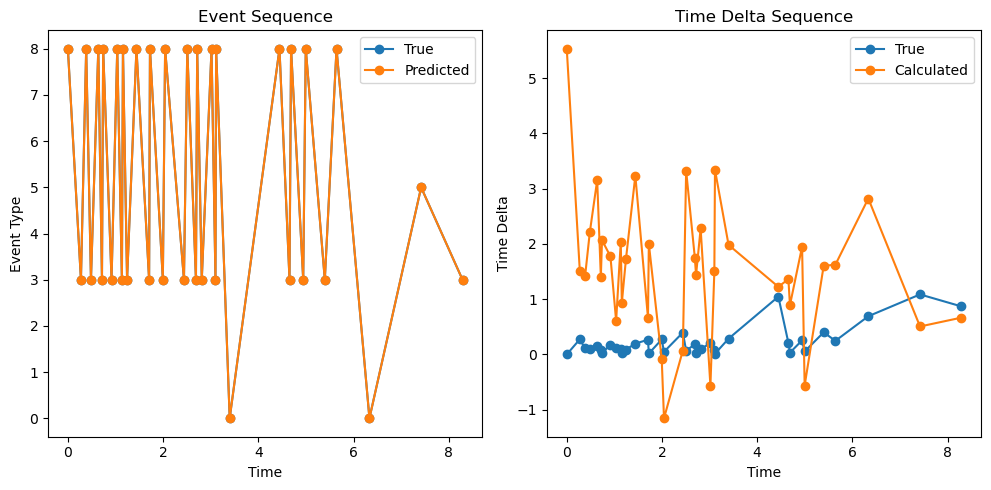

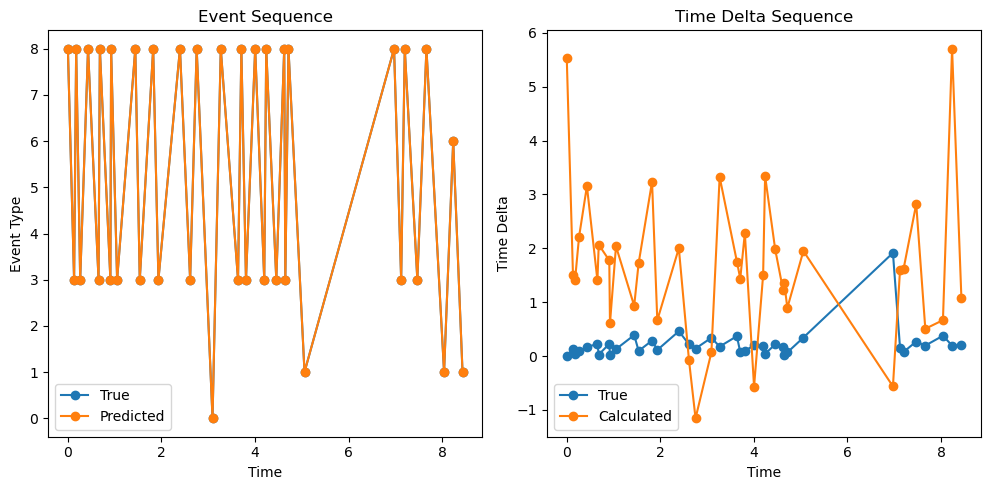

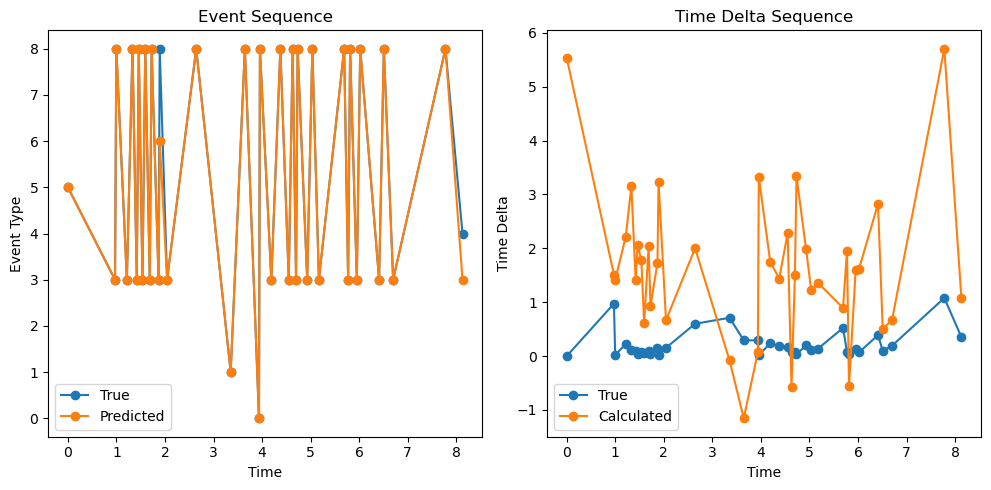

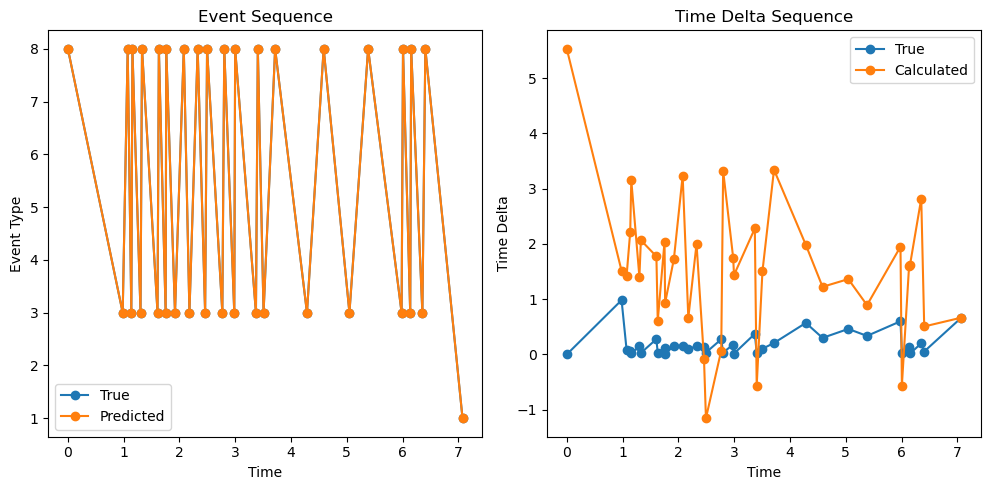

In [31]:
# plot the event sequences and the predicted event sequences
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = vae_model(batch)
    plot_event_sequence(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        vae_eval_metrics['predicted_intervals'], 
        decoder_output
    )
    break

In [32]:
def plot_event_sequence_with_intensity(
    time_seqs,
    type_seqs,
    time_delta_seqs,
    sequence_length,
    tpp_eval_metrics,
    vae_eval_metrics,
    decoder_output_tpp,
    decoder_output_vae,
    num_samples=5,
):
    """
    Plot event sequences and compare deterministic vs probabilistic intensity functions.

    Args:
        time_seqs (torch.Tensor): Ground truth event times.
        type_seqs (torch.Tensor): Ground truth event types.
        time_delta_seqs (torch.Tensor): Ground truth time deltas.
        sequence_length (torch.Tensor): Sequence lengths.
        tpp_eval_metrics (dict): Evaluation metrics from the TPP model.
        vae_eval_metrics (dict): Evaluation metrics from the VAE model.
        decoder_output_tpp (object): Decoder output from TPP model.
        decoder_output_vae (object): Decoder output from VAE model.
        num_samples (int): Number of sequences to plot.
    """
    predicted_intervals_tpp = tpp_eval_metrics["predicted_intervals"]
    predicted_intervals_vae = vae_eval_metrics["predicted_intervals"]

    for i in range(num_samples):
        time_seq = time_seqs[i].detach().cpu().numpy()
        type_seq = type_seqs[i].detach().cpu().numpy()
        time_delta_seq = time_delta_seqs[i].detach().cpu().numpy()
        seq_len = sequence_length[i].item()

        pred_time_delta_tpp = (
            predicted_intervals_tpp[i].detach().cpu().numpy()
            if isinstance(predicted_intervals_tpp, torch.Tensor)
            else predicted_intervals_tpp
        )
        pred_time_delta_vae = (
            predicted_intervals_vae[i].detach().cpu().numpy()
            if isinstance(predicted_intervals_vae, torch.Tensor)
            else predicted_intervals_vae
        )

        pred_event_types_tpp = torch.argmax(decoder_output_tpp.mark_logits[i], dim=-1).detach().cpu().numpy()
        pred_event_types_vae = torch.argmax(decoder_output_vae.mark_logits[i], dim=-1).detach().cpu().numpy()

        plt.figure(figsize=(18, 10))
        plt.subplot(2, 2, 1)
        plt.plot(time_seq[:seq_len], type_seq[:seq_len], "o-", label="True")
        plt.plot(
            time_seq[:seq_len],
            pred_event_types_tpp[:seq_len],
            "o-",
            label="TPP Predicted",
        )
        plt.plot(
            time_seq[:seq_len],
            pred_event_types_vae[:seq_len],
            "o-",
            label="VAE Predicted",
        )
        plt.xlabel("Time")
        plt.ylabel("Event Type")
        plt.title("Event Sequence")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(time_seq[:seq_len], time_delta_seq[:seq_len], "o-", label="True")
        plt.plot(
            time_seq[:seq_len],
            pred_time_delta_tpp[:seq_len],
            "o-",
            label="TPP Predicted",
        )
        plt.plot(
            time_seq[:seq_len],
            pred_time_delta_vae[:seq_len],
            "o-",
            label="VAE Predicted",
        )
        plt.xlabel("Time")
        plt.ylabel("Time Delta")
        plt.title("Time Delta Sequence")
        plt.legend()


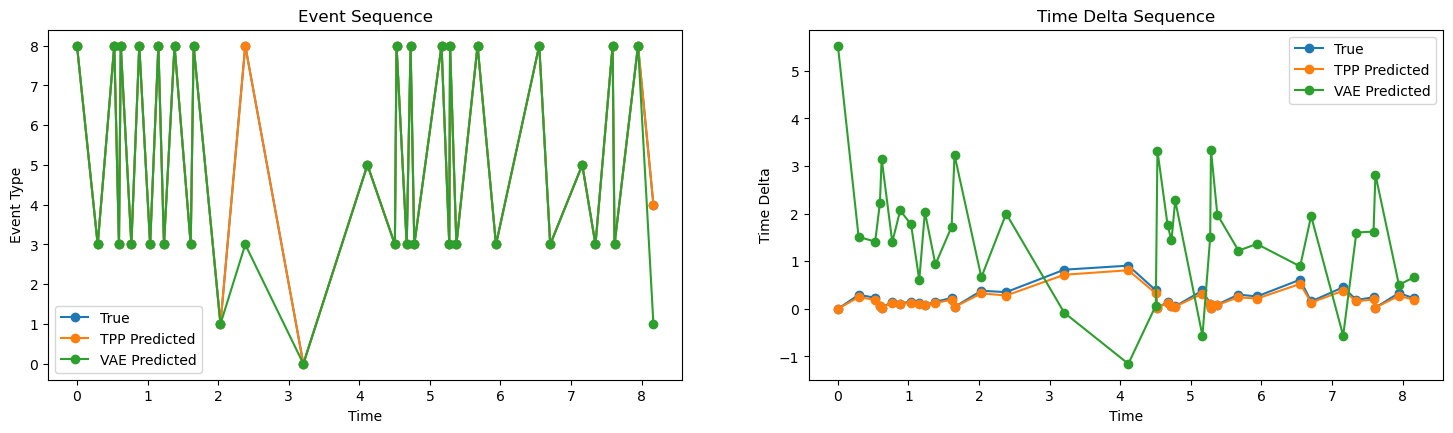

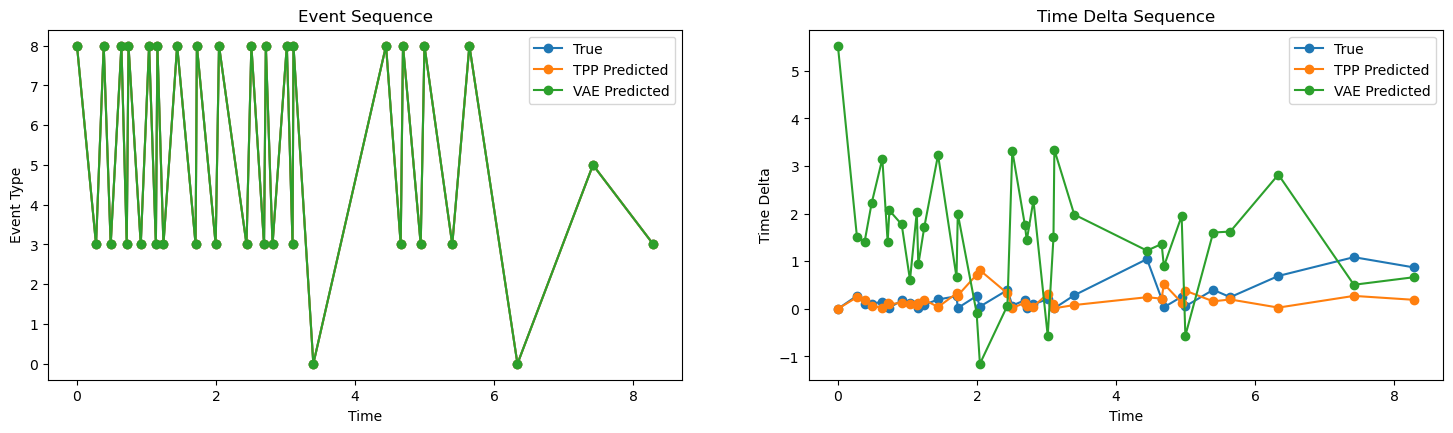

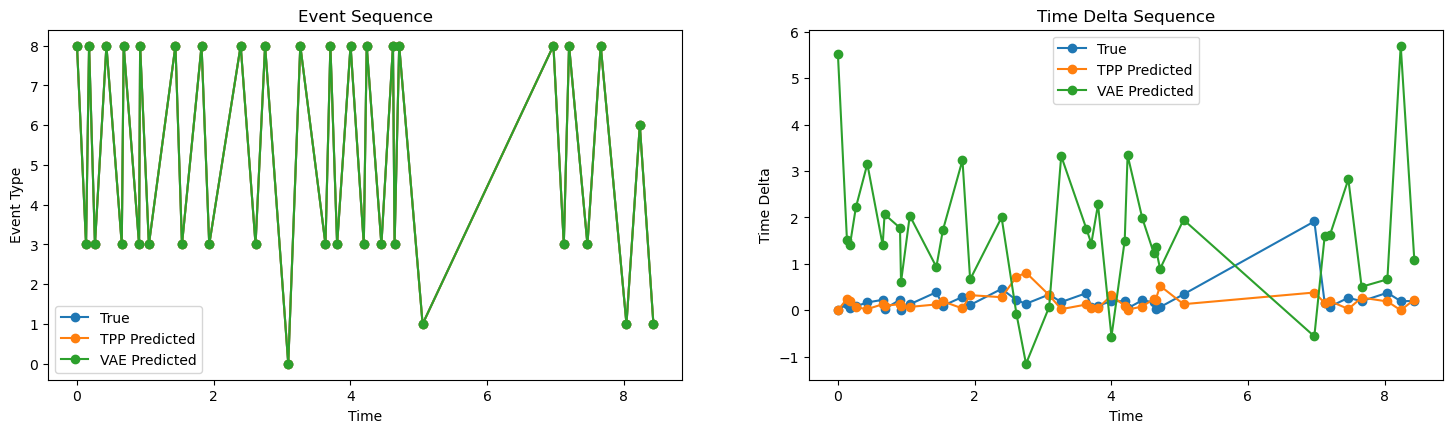

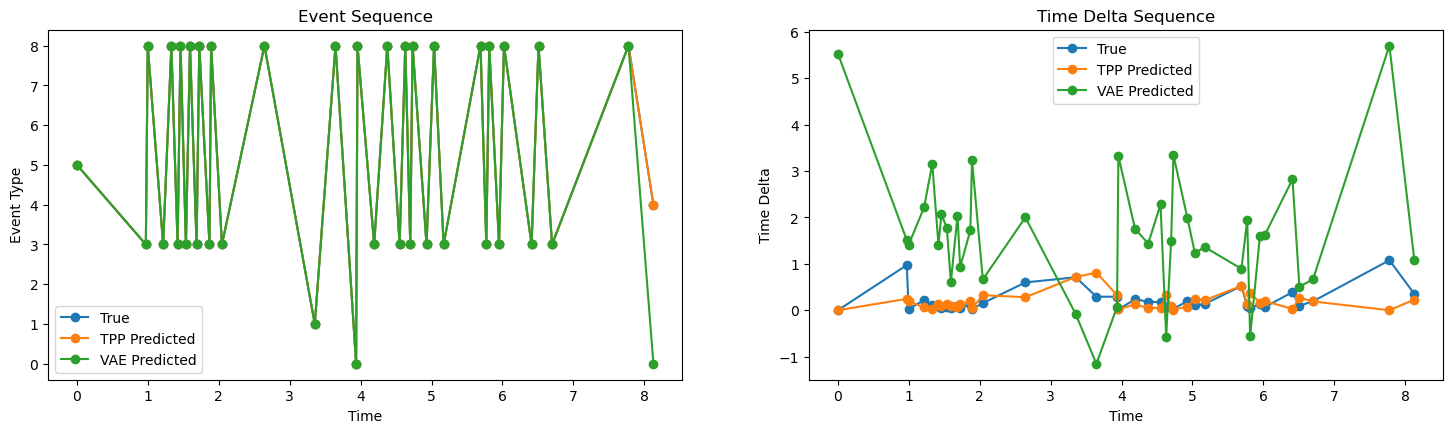

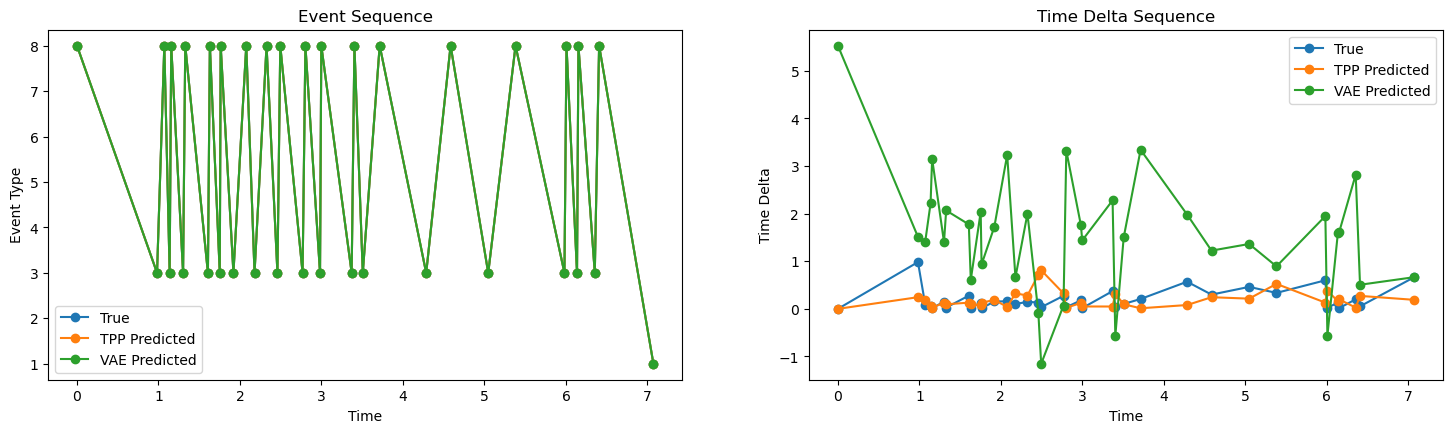

In [ ]:
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}

    decoder_output_tpp = tpp_model(batch)
    decoder_output_vae = vae_model(batch)

    plot_event_sequence_with_intensity(
        batch["time_seqs"],
        batch["type_seqs"],
        batch["time_delta_seqs"],
        batch["sequence_length"],
        tpp_eval_metrics,
        vae_eval_metrics,
        decoder_output_tpp,
        decoder_output_vae,
    )
    break

In [60]:
next(test_loader.__iter__())['type_seqs']

tensor([[ 8,  3,  8,  ...,  4, 10, 10],
        [ 8,  3,  8,  ...,  3, 10, 10],
        [ 8,  3,  8,  ...,  1,  6,  1],
        ...,
        [ 5,  3,  8,  ...,  3,  8,  3],
        [ 8,  3,  8,  ...,  3,  8,  3],
        [ 8,  3,  8,  ...,  3, 10, 10]])

In [49]:
len(test_loader)

13

Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([32, 38, 32])
Shape of mu: torch.Size([16, 38, 32])
Len of mus: 400
Len of event_types: 400
Shape of mus: (400, 38, 32)
Shape of event_types: (400, 38)


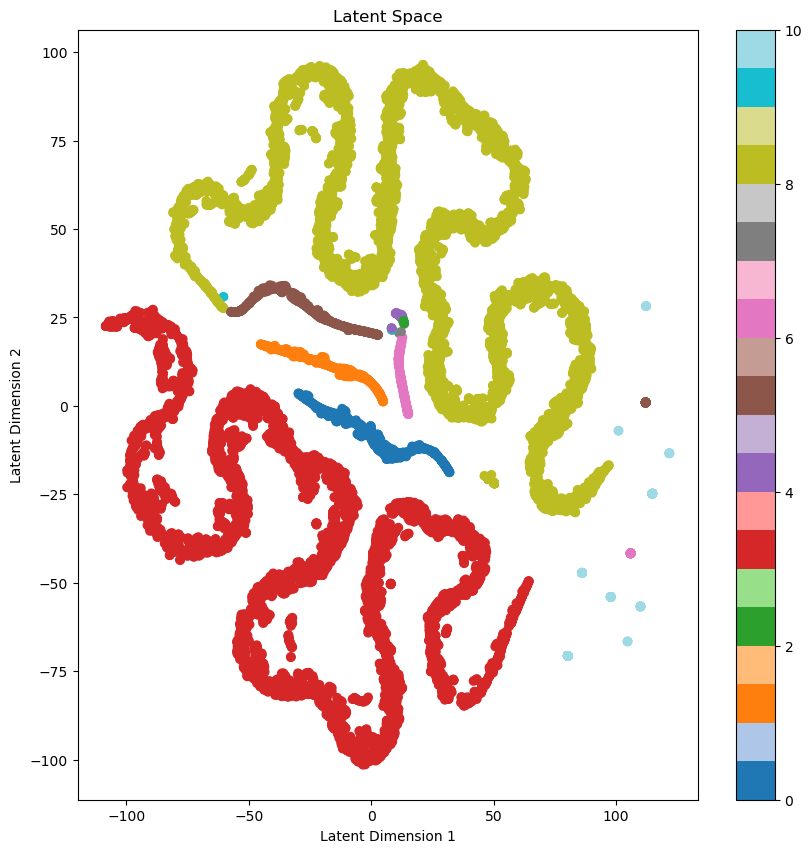

In [51]:
# manifold learning visualization
from sklearn.manifold import TSNE

# plot latent space using mu from the forward pass
def plot_latent_space(model, data_loader, device):
    """
    Plot latent space of the VAE model using mu from the forward pass.

    Args:
        model (VAETPPModel): VAE model.
        data_loader (DataLoader): Data loader.
        device (str): Device to run the model on.
    """
    model.eval()
    mus = []
    event_types = []
    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            output = model(batch)
            mu = output.mu
            mus.append(mu)
            event_types.append(batch["type_seqs"])
            
            print("Shape of mu:", mu.shape)
    
    mus = torch.cat(mus, dim=0).cpu().numpy()
    event_types = torch.cat(event_types, dim=0).cpu().numpy()
    
    print("Len of mus:", len(mus))
    print("Len of event_types:", len(event_types))
    
    print("Shape of mus:", mus.shape)
    print("Shape of event_types:", event_types.shape)
    
    # reduce dimensionality using t-SNE    
    tsne = TSNE(n_components=2, random_state=0)
    
    # fix shape mismatch by reshaping mus
    mus = mus.reshape(-1, mus.shape[-1])
    mus = tsne.fit_transform(mus)
    
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(mus[:, 0], mus[:, 1], c=event_types, cmap="tab20")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space")
    plt.colorbar(scatter)
    plt.show()

plot_latent_space(vae_model, test_loader, device)

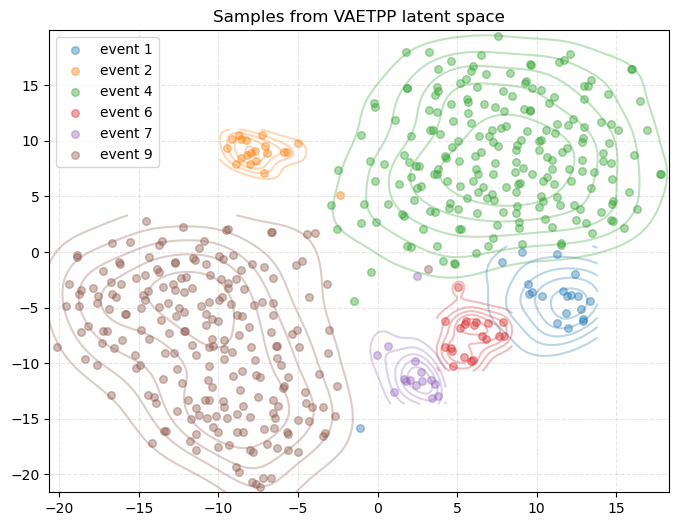

In [66]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.manifold import TSNE

def visualize_vae_latent_space(model, data_loader, device, max_samples=100):
    model.eval()
    
    batch = next(iter(data_loader))
    batch = {k: v.to(device) for k, v in batch.items()}
    sequence_lengths = batch["sequence_length"].to(device)
    
    # identify the padding tokens
    mask = torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device) < sequence_lengths.unsqueeze(1)
    mask = mask.cpu().numpy()
    
    with torch.no_grad():
        output = model(batch)
        mu = output.mu.cpu().numpy()
        logvar = output.logvar.cpu().numpy()
        event_types = batch["type_seqs"].cpu().numpy()
        
        mu = mu[mask].reshape(-1, mu.shape[-1])
        logvar = logvar[mask].reshape(-1, logvar.shape[-1])
        event_types = event_types[mask].reshape(-1)
        
        if len(mu) > max_samples:
            idx = np.random.choice(len(mu), max_samples, replace=False)
            mu = mu[idx]
            logvar = logvar[idx]
            event_types = event_types[idx]
    
    std = np.exp(0.5 * logvar)
    n_samples_per_point = 5
    samples = []
    sample_types = []
    
    for i in range(len(mu)):
        for _ in range(n_samples_per_point):
            sample = mu[i] + np.random.randn(*mu[i].shape) * std[i]
            samples.append(sample)
            sample_types.append(event_types[i])
    
    samples = np.stack(samples)
    sample_types = np.array(sample_types)
    
    tsne = TSNE(n_components=2, random_state=42)
    samples_2d = tsne.fit_transform(samples)
    
    plt.figure(figsize=(8, 6))
    
    # Get default color cycle
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for idx, event_type in enumerate(np.unique(event_types)):
        mask = sample_types == event_type
        points = samples_2d[mask]
        
        kde = gaussian_kde(points.T)
        x_min, x_max = points[:, 0].min() - 0.5, points[:, 0].max() + 0.5
        y_min, y_max = points[:, 1].min() - 0.5, points[:, 1].max() + 0.5
        
        x = np.linspace(x_min, x_max, 50)
        y = np.linspace(y_min, y_max, 50)
        X, Y = np.meshgrid(x, y)
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = kde(positions).reshape(X.shape)
        
        color = colors[idx % len(colors)]
        label = f'event {event_type + 1}'
        
        plt.contour(X, Y, Z, levels=5, colors=color, alpha=0.3)
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.4, label=label, s=30)
    
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.title('Samples from VAETPP latent space')
    
    return plt.gcf()

# Usage
fig = visualize_vae_latent_space(vae_model, test_loader, device, max_samples=100)
plt.show()

In [59]:
# def cosine_annealing_schedule(
#     step: int,
#     n_steps: int,
#     beta_start: float,
#     beta_end: float,
#     warmup_steps: int,
# ) -> float:
#     """Cyclic cosine annealing schedule for beta."""
#     if step <= warmup_steps:
#         return beta_start
#     else:
#         cycle_step = (step - warmup_steps) % n_steps
#         progress = cycle_step / n_steps
#         return beta_end + 0.5 * (beta_start - beta_end) * (
#             1 + torch.cos(torch.tensor(progress * 3.141592653589793))
#         )
        
# # Visualize the schedule
# warmup_steps = 40
# steps = np.arange(0, num_steps)
# betas = [cosine_annealing_schedule(step, num_steps // 5, 0, 0.5, warmup_steps) for step in steps]

# plt.figure(figsize=(10, 5))
# plt.plot(steps, betas, label='Beta Schedule')
# plt.xlabel('Steps')
# plt.ylabel('Beta')
# plt.title('Cosine Annealing Schedule for Beta')
# plt.legend()
# plt.show()